In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"

In [3]:
%%bash
ls -la resized | head -4
head hvc_annotations.csv

total 195224
drwxr-xr-x 2 root root 299008 Dec 13 09:53 .
drwxr-xr-x 1 root root   4096 Dec 26 05:11 ..
-rw-r--r-- 1 root root  12077 Dec 13 09:53 10000.jpg
filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg
images/Set1/32490_1.jpg,male,Good,35-45,slightly-overweight,None,Normal,Neutral,Front-Frontish,resized/6.jpg
images/Set1/IMG (219).jpg,male,Bad,25-3

In [0]:
%tensorflow_version 1.x
import os

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from keras.utils import plot_model
from IPython.display import Image

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf

from keras.applications import VGG16, ResNet50V2
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

import keras
from keras.regularizers import l2
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D


In [0]:
%load_ext tensorboard

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=0)

In [7]:
%tensorboard --logdir logs

In [0]:
# !kill 929

In [0]:
annotation_csv = Path("hvc_annotations.csv")
images_root = Path("resized")

In [0]:
df = pd.read_csv(annotation_csv) 

In [10]:
df.head()

,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [11]:
df.describe().T

,count,unique,top,freq
filename,13573,13573,images/Set1/20610_8.jpg,1
gender,13573,2,male,7636
imagequality,13573,3,Average,7509
age,13573,5,25-35,5411
weight,13573,4,normal-healthy,8628
carryingbag,13573,3,None,7649
footwear,13573,3,Normal,6038
emotion,13573,4,Neutral,9660
bodypose,13573,3,Front-Frontish,8383
image_path,13573,13573,resized/11121.jpg,1


In [12]:
gender_encoder = LabelEncoder().fit(df.gender)
print(gender_encoder.classes_)
gender_encoder.transform(df.gender)

['female' 'male']


array([1, 0, 1, ..., 0, 0, 1])

In [0]:
def encode_multi_categories(x, n=3, order_dict=None):
    """`x` is numpy array"""
    if order_dict is None:
        x_encoded = LabelEncoder().fit_transform(x)
        return np.eye(n)[x_encoded]
    return np.eye(n)[order_dict[x]]

In [0]:
def resize_and_pad(image, size=224, fill=0):
    orig_size = image.shape[:2] 
    ratio = float(size)/max(orig_size)
    new_size = tuple([int(x*ratio) for x in orig_size])

    image = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = size - new_size[1]
    delta_h = size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [fill]*3
    return cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

In [0]:
def read_image(filename, resize=None, augment_fn=None):
    image = cv2.imread(filename)
    if resize is not None:
        image = resize_and_pad(image, resize)
    return image

In [0]:
x = read_image(df.image_path[11005], resize=224)

In [17]:
df.iloc[11005]

filename        images/Set3/34890_1.jpg
gender                           female
imagequality                        Bad
age                               35-45
weight                      over-weight
carryingbag                        None
footwear                         Normal
emotion                         Neutral
bodypose                 Front-Frontish
image_path            resized/11007.jpg
Name: 11005, dtype: object

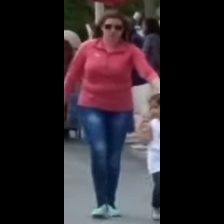

In [18]:
cv2_imshow(x)

In [19]:
x.shape

(224, 224, 3)

In [0]:
X = df.image_path.apply(partial(read_image, resize=224)).values
X = np.stack(X)
X = X.astype('float32')/255.

In [21]:
X[0].max()

1.0

In [0]:

# gender
gender_dict = {"female": 0, "male": 1}
y_gender = np.stack(
    df.gender.apply(partial(encode_multi_categories, n=2, order_dict=gender_dict)).values
)

# image quality
image_encode_dict = dict(zip(("Bad", "Average", "Good"), range(3)))
y_image_quality = np.stack(
    df.imagequality.apply(partial(encode_multi_categories, n=3, order_dict=image_encode_dict)).values
)

# age
unique_ages = df.age.unique()
age_dict = dict(zip(sorted(unique_ages),range(len(unique_ages))))
y_age = np.stack(
    df.age.apply(partial(encode_multi_categories, n=len(unique_ages), order_dict=age_dict)).values
)

# weight
unique_weight = ['underweight','normal-healthy', 'slightly-overweight', 'over-weight']
weight_dict = dict(zip(unique_weight, range(len(unique_weight))))
y_weight = np.stack(
    df.weight.apply(partial(encode_multi_categories, n=len(unique_weight), order_dict=weight_dict)).values
)


# bag
unique_bags = df.carryingbag.unique()
bag_dict = dict(zip(sorted(unique_bags),range(len(unique_bags))))
y_bag = np.stack(
    df.carryingbag.apply(partial(encode_multi_categories, n=len(unique_bags), order_dict=bag_dict)).values
)

# pose
unique_poses = df.bodypose.unique()
pose_dict = dict(zip(sorted(unique_poses),range(len(unique_poses))))
y_pose = np.stack(
    df.bodypose.apply(partial(encode_multi_categories, n=len(unique_poses), order_dict=pose_dict)).values
)

# footwear
unique_footwears = df.footwear.unique()
footwear_dict = dict(zip(sorted(unique_footwears),range(len(unique_footwears))))
y_footwear = np.stack(
    df.footwear.apply(partial(encode_multi_categories, n=len(unique_footwears), order_dict=footwear_dict)).values
)

# emotion
unique_emotions = df.emotion.unique()
emotion_dict = dict(zip(unique_emotions, range(len(unique_emotions))))
y_emotion = np.stack(
    df.emotion.apply(partial(encode_multi_categories, n=len(unique_emotions), order_dict=emotion_dict)).values
)


In [0]:
X_train, X_valid, y_train_idx, y_valid_idx = train_test_split(X, range(len(X)), test_size=0.2)

y_train = {
    "gender_output": y_gender[y_train_idx], 
    "image_quality_output": y_image_quality[y_train_idx],
    "age_output": y_age[y_train_idx],
    "weight_output": y_weight[y_train_idx],
    "bag_output": y_bag[y_train_idx],
    "pose_output": y_pose[y_train_idx],
    "footwear_output": y_footwear[y_train_idx],
    "emotion_output": y_emotion[y_train_idx],

}

y_valid = {
    "gender_output": y_gender[y_valid_idx], 
    "image_quality_output": y_image_quality[y_valid_idx],
    "age_output": y_age[y_valid_idx],
    "weight_output": y_weight[y_valid_idx],
    "bag_output": y_bag[y_valid_idx],
    "pose_output": y_pose[y_valid_idx],
    "footwear_output": y_footwear[y_valid_idx],
    "emotion_output": y_emotion[y_valid_idx],

}

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 32
    stage 1: 32x32, 64
    stage 2: 16x16, 128
    stage 3:  8x8,  512
    # Arguments
        input_shape (tensor): shape of input image tensor
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    num_filters = 64
    num_res_blocks = 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                   num_filters=64,
                   kernel_size=7,
                   strides=2,
                   batch_normalization=False)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    # Instantiate the stack of residual units
    for stack in range(4):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                              num_filters=num_filters,
                              strides=strides)
            y = resnet_layer(inputs=y,
                              num_filters=num_filters,
                              activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
            # linear projection residual shortcut connection to match
            # changed dims
                x = resnet_layer(inputs=x,
                                  num_filters=num_filters,
                                  kernel_size=1,
                                  strides=strides,
                                  activation=None,
                                  batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=7)(x)
    #y = Flatten()(x)
    # outputs = Dense(num_classes,
    #                 activation='softmax',
    #                 kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=x)
    return model

In [26]:
backbone = resnet_v1(input_shape=(224, 224, 3))

In [0]:
# backbone.summary()

In [0]:
# plot_model(backbone, show_shapes=True, show_layer_names=True, to_file='backbone.png')
# Image(retina=True, filename='backbone.png')

In [0]:
del backbone

In [0]:
backbone = ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(256, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.5)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck

# heads
gender = Dense(2, activation="sigmoid", name="gender_output")(build_tower(neck))
image_quality = Dense(3, activation="softmax", name="image_quality_output")(build_tower(neck))
age = Dense(len(unique_ages), activation="softmax", name="age_output")(build_tower(neck))
weight = Dense(len(unique_weight), activation="softmax", name="weight_output")(build_tower(neck))
bag = Dense(len(unique_bags), activation="softmax", name="bag_output")(build_tower(neck))
footwear = Dense(len(unique_footwears), activation="sigmoid", name="footwear_output")(build_tower(neck))
emotion = Dense(len(unique_emotions), activation="sigmoid", name="emotion_output")(build_tower(neck))
pose = Dense(len(unique_poses), activation="sigmoid", name="pose_output")(build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [33]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [34]:
df.describe()

,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
count,13573,13573,13573,13573,13573,13573,13573,13573,13573,13573
unique,13573,2,3,5,4,3,3,4,3,13573
top,images/Set1/20610_8.jpg,male,Average,25-35,normal-healthy,None,Normal,Neutral,Front-Frontish,resized/11121.jpg
freq,1,7636,7509,5411,8628,7649,6038,9660,8383,1


In [0]:
class MultiOutputDataGenerator(ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict


datagen = MultiOutputDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [36]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",

}
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.0005, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
batch_size=32
epochs=100

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'resnet_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, tensorboard_callback]

In [0]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs, verbose=1,
          validation_data=(X_valid, y_valid),
          steps_per_epoch=424,
          callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
424/424 [==============================] - 160s 377ms/step - loss: 8.1549 - gender_output_loss: 0.6754 - image_quality_output_loss: 1.0223 - age_output_loss: 1.4926 - weight_output_loss: 1.0443 - bag_output_loss: 0.9559 - footwear_output_loss: 1.0260 - pose_output_loss: 0.9518 - emotion_output_loss: 0.9867 - gender_output_acc: 0.5661 - image_quality_output_acc: 0.5293 - age_output_acc: 0.3659 - weight_output_acc: 0.6230 - bag_output_acc: 0.5382 - footwear_output_acc: 0.4878 - pose_output_acc: 0.6099 - emotion_output_acc: 0.7000 - val_loss: 7.6554 - val_gender_output_loss: 0.6316 - val_image_quality_output_loss: 0.9874 - val_age_output_loss: 1.4222 - val_weight_output_loss: 0.9605 - val_bag_output_loss: 0.9203 - val_footwear_output_loss: 0.9487 - val_pose_output_loss: 0.8999 - val_emotion_output_loss: 0.8848 - val_gender_output_acc: 0.6026 - val_image_quality_output_acc: 0.5499 - 

In [34]:
model.save_weights("model-epoch-100.h5")
print("Saved model to disk")

Saved model to disk
